In [40]:
import os
import importlib

import chess
import chess.svg
from jax import random as jrandom
import numpy as np

#os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")

In [41]:
from searchless_chess.src import transformer
importlib.reload(transformer)
from searchless_chess.src import tokenizer
from searchless_chess.src import training_utils
from searchless_chess.src import utils
from searchless_chess.src.engines import engine
from searchless_chess.src.engines import neural_engines
import searchless_chess.src.engines.constants as constants

In [42]:
# @title Create the predictor (9M)

policy = 'action_value'
num_return_buckets = 128
output_size = num_return_buckets
predictor_config = transformer.TransformerConfig(
    vocab_size=utils.NUM_ACTIONS,
    output_size=output_size,
    pos_encodings=transformer.PositionalEncodings.LEARNED,
    max_sequence_length=tokenizer.SEQUENCE_LENGTH + 2,
    num_heads=8,
    num_layers=8,
    embedding_dim=256,
    apply_post_ln=True,
    apply_qk_layernorm=False,
    use_causal_mask=False,
)

predictor = transformer.build_transformer_predictor(config=predictor_config)

In [43]:
# @title Load the predictor parameters
os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")
checkpoint_dir = os.path.join(
    os.getcwd(),
    f'searchless_chess/checkpoints/9M',
)
dummy_params = predictor.initial_params(
    rng=jrandom.PRNGKey(6400000),
    targets=np.zeros((1, 1), dtype=np.uint32),
)
params = training_utils.load_parameters(
    checkpoint_dir=checkpoint_dir,
    params=dummy_params,
    use_ema_params=True,
    step=-1,
)

Init transformer decoder
targets: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))
inputs: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))
embeddings 1: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
pos_encodings: (Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
final_embed: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
embeddings: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
attention_input: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
inputs_q: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
inputs_kv: (Array(1, dtype=int32, weak

mlp_output: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
h: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
logits: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(128, dtype=int32, weak_type=True))
End transformer decoder
softmax: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(128, dtype=int32, weak_type=True))


- Visualizar capas de atención 
- Heatmaps sobre el tablero
- Integrated Gradients
- SHAP
- Probing

## Visualizar capas de atención

In [44]:
print('Parametros de 9M:')
print(params.keys())
print('embed:')
print(params['embed'].keys())
print(params['embed']['embeddings'].shape)
print('embed posicional:')
print(params['embed_1'].keys())
print(params['embed_1']['embeddings'].shape)
print('layer_norm:')
print(params['layer_norm'].keys())
print(params['layer_norm']['offset'].shape)
print(params['layer_norm']['scale'].shape)
print('linear:')
print(params['linear'].keys())
print(params['linear']['w'].shape)
print('multi_head_dot_product_attention/linear')
print(params['multi_head_dot_product_attention/linear'].keys())
print(params['multi_head_dot_product_attention/linear']['w'].shape)

Parametros de 9M:
dict_keys(['embed', 'embed_1', 'layer_norm', 'layer_norm_1', 'layer_norm_10', 'layer_norm_11', 'layer_norm_12', 'layer_norm_13', 'layer_norm_14', 'layer_norm_15', 'layer_norm_16', 'layer_norm_2', 'layer_norm_3', 'layer_norm_4', 'layer_norm_5', 'layer_norm_6', 'layer_norm_7', 'layer_norm_8', 'layer_norm_9', 'linear', 'linear_1', 'linear_10', 'linear_11', 'linear_12', 'linear_13', 'linear_14', 'linear_15', 'linear_16', 'linear_17', 'linear_18', 'linear_19', 'linear_2', 'linear_20', 'linear_21', 'linear_22', 'linear_23', 'linear_24', 'linear_3', 'linear_4', 'linear_5', 'linear_6', 'linear_7', 'linear_8', 'linear_9', 'multi_head_dot_product_attention/linear', 'multi_head_dot_product_attention/linear_1', 'multi_head_dot_product_attention/linear_2', 'multi_head_dot_product_attention/linear_3', 'multi_head_dot_product_attention_1/linear', 'multi_head_dot_product_attention_1/linear_1', 'multi_head_dot_product_attention_1/linear_2', 'multi_head_dot_product_attention_1/linear_3

In [45]:
print(params['embed_1']['embeddings'])

[[-1.2726891  -1.1974516   0.54013664 ... -1.2665184   1.1131856
  -0.91666424]
 [ 0.8711757   2.336499   -0.02174549 ...  1.2731202   0.39021498
  -1.5429358 ]
 [-0.18851171 -1.5562397  -1.0292208  ...  1.1008565  -0.04924524
  -0.22640269]
 ...
 [ 1.2551732  -0.8144249   0.87325716 ...  0.39124066  2.320126
   1.9397182 ]
 [ 0.60317576 -0.47329235 -1.7449214  ...  0.7880165  -0.63051313
   0.6396439 ]
 [ 0.17928971  1.3429705  -1.3846192  ...  1.3038887  -0.2870525
   0.36313894]]


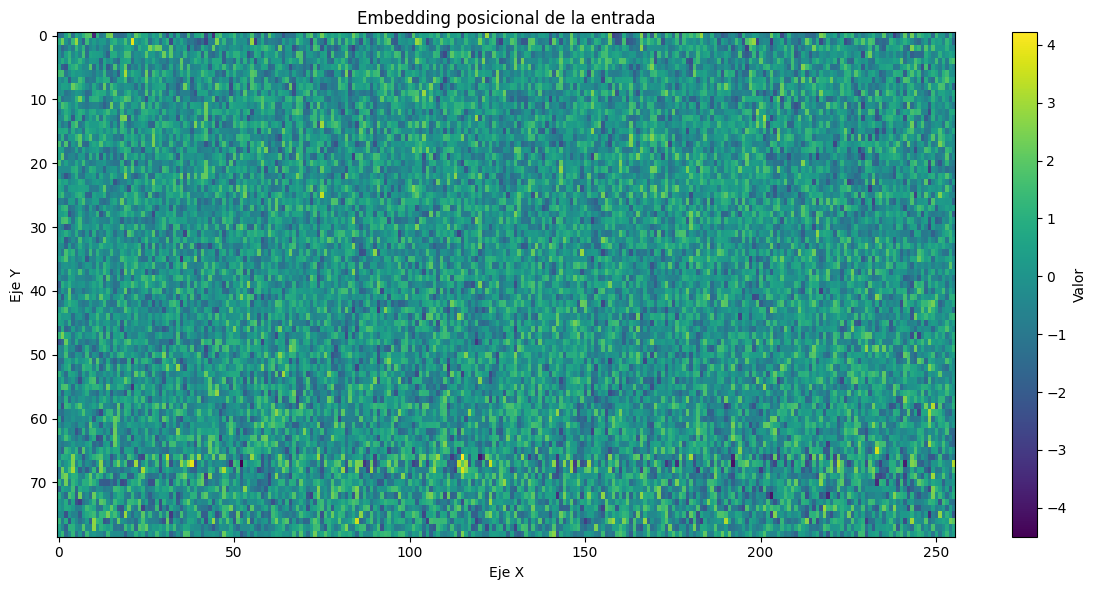

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un array de ejemplo de tamaño 79x256
data = params['embed_1']['embeddings']

# Crear el mapa de calor
plt.figure(figsize=(12, 6))
plt.imshow(data, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Embedding posicional de la entrada')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.tight_layout()
plt.show()


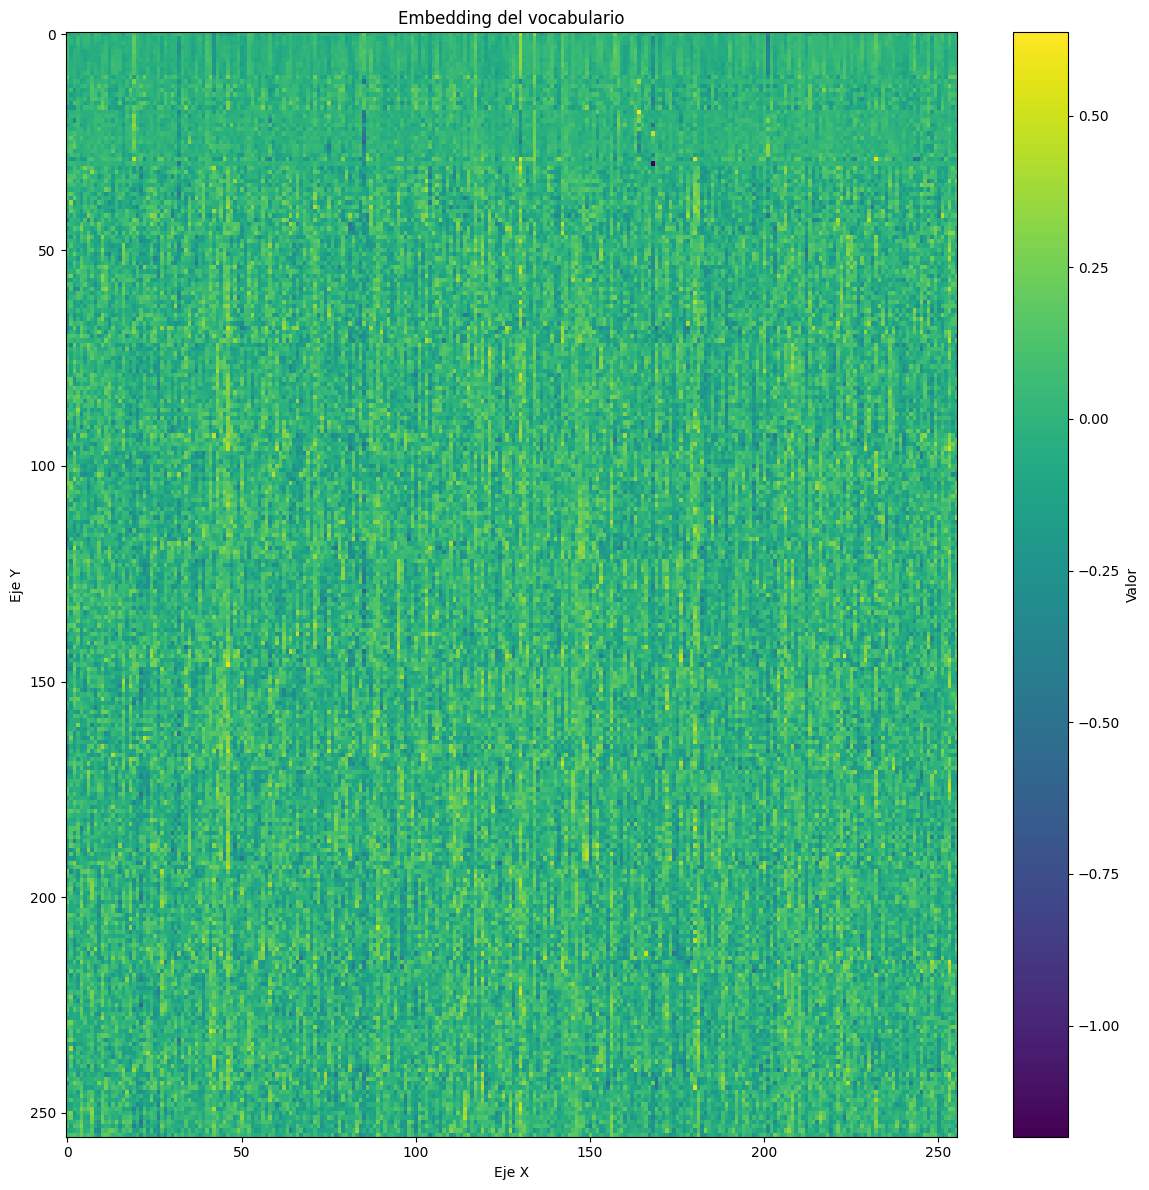

In [57]:
# Crear un array de ejemplo de tamaño 79x256
data = params['embed']['embeddings'][:256,:]

# Crear el mapa de calor
plt.figure(figsize=(12, 12))
plt.imshow(data, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Embedding del vocabulario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.tight_layout()
plt.show()

In [ ]:
# IDEA: Extraer solo embeddings de piezas o posiciones y ver si tienen características en común
# En qué se diferencian los embeddings de la misma pieza según el color?

In [47]:
# @title Create the engine

predict_fn = neural_engines.wrap_predict_fn(predictor, params, batch_size=1)
_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

neural_engine = neural_engines.ENGINE_FROM_POLICY[policy](
    return_buckets_values=return_buckets_values,
    predict_fn=predict_fn,
    temperature=0.005,
)

In [48]:
transformer.foooo()

foo


1

In [49]:
os.chdir('searchless_chess/checkpoints/')
neural_engine = constants.ENGINE_BUILDERS['9M']()
os.chdir('../../')

Init transformer decoder
targets: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))
inputs: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))
embeddings 1: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
pos_encodings: (Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
final_embed: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
embeddings: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
attention_input: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
inputs_q: (Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(256, dtype=int32, weak_type=True))
inputs_kv: (Array(1, dtype=int32, weak

In [50]:
# @title Play a move with the agent
board = chess.Board()
best_move = neural_engine.play(board)
print(f'Best move: {best_move}')
print(neural_engine.analyse(board)['log_probs'])

Init transformer decoder
End transformer decoder
attention_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
pos_encodings: (Array(79, dtype=int32), Array(256, dtype=int32))
inputs_q: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
mlp_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
targets: (Array(1, dtype=int32), Array(79, dtype=int32))
inputs: (Array(1, dtype=int32), Array(79, dtype=int32))
mlp_output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
inputs_kv: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
embeddings 1: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
q: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
final_embed: (Array(1, dtype=int

In [51]:
# @title Compute the win percentages for all legal moves

board = chess.Board()
results = neural_engine.analyse(board)
buckets_log_probs = results['log_probs']

# Compute the expected return.
win_probs = np.inner(np.exp(buckets_log_probs), return_buckets_values)
sorted_legal_moves = engine.get_ordered_legal_moves(board)

print(board.fen())
print(f'Win percentages:')
for i in np.argsort(win_probs)[::-1]:
  print(f'  {sorted_legal_moves[i].uci()} -> {100*win_probs[i]:.1f}%')

Init transformer decoder
End transformer decoder
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
pos_encodings: (Array(79, dtype=int32), Array(256, dtype=int32))
attention_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
mlp_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
targets: (Array(1, dtype=int32), Array(79, dtype=int32))
inputs_q: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
inputs: (Array(1, dtype=int32), Array(79, dtype=int32))
mlp_output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
embeddings 1: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
inputs_kv: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
attention_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
final_embed: (Arra

output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(8, dtype=int32), Array(32, dtype=int32))
output reshaped: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
output final: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
attention_output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(8, dtype=int32), Array(32, dtype=int32))
mlp_input: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
output reshaped: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
mlp_output: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
output final: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
h: (Array(1, dtype=int32), Array(79, dtype=int32), Array(256, dtype=int32))
attention_input: (Array(1, d